In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [46]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Matplotlib Plots

In [4]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [5]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [6]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [7]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [8]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue=None):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [9]:
def show_catplot(df, x_label, y_label, title="catplot", hue=None):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

## Outliers

In [10]:
def explore_outliers(df,columns):
    number_df = df[columns].select_dtypes(include="number")
    n_columns = number_df.columns
    # normalização para ser visualmente perceptivel nos plots
    scaler = MinMaxScaler()
    number_df_scaled = pd.DataFrame(scaler.fit_transform(number_df),columns=n_columns)

    for i in range(0, len(n_columns),7):
        show_boxplot(df=number_df_scaled[n_columns[i:i+7]])
        
# esta função faz um loop de 7 em 7 colunas por todas as colunas do dataset para uma analise geral dos outliers.
# esta operacao é demorada e nao muito boa porque 2181 / 7 = 300 vezes


In [11]:
def detect_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar os outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    show_boxplot(title=f"{column} boxplot",df=df[[column]])

    print(outliers[column])

# IQR method 
## considera como outliers os dados que estao 1.5*IQR acima e abaixo do primeiro e terceiro quartil, respetivamente. IQR = Q3 - Q1

## Category Encoder and Decoder
bastante útil para poder codificar e posteriormente decodificar categorical features

In [94]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [56]:
le_make_control = target_encoder(control_df)
le_make_train = target_encoder(train_df)

## Basic Exploration

In [92]:
def main_exploration(df):
    print(df.shape) 

In [93]:
main_exploration(control_df)
main_exploration(train_df)
main_exploration(test_df)

(305, 2163)
(305, 2025)
(100, 2161)


In [36]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())
    detect_outliers(df,"Age")

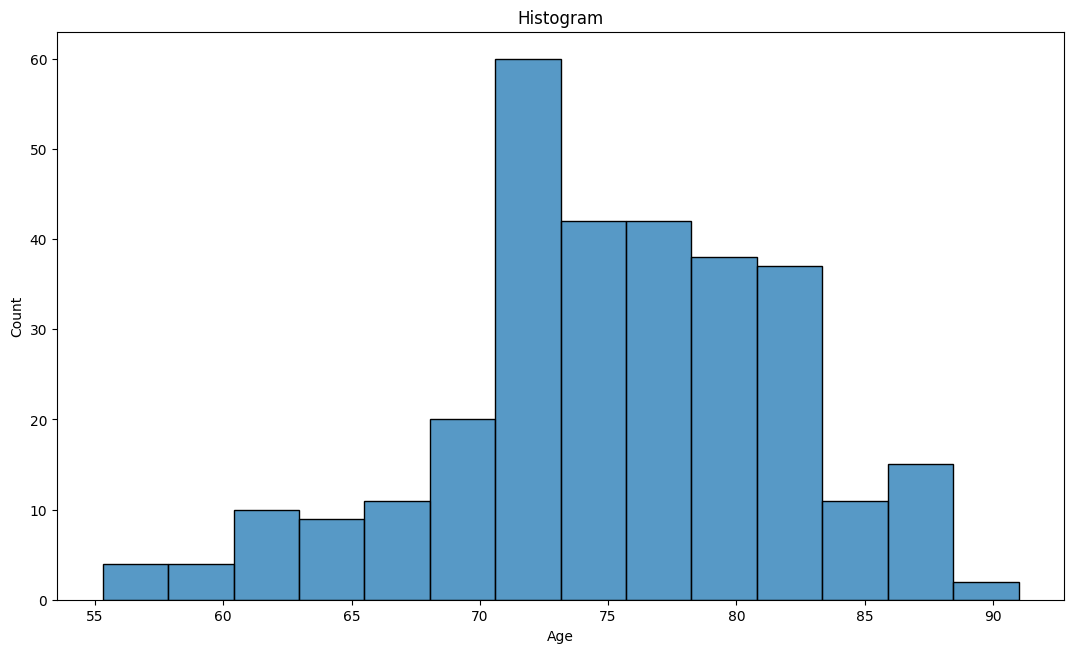

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


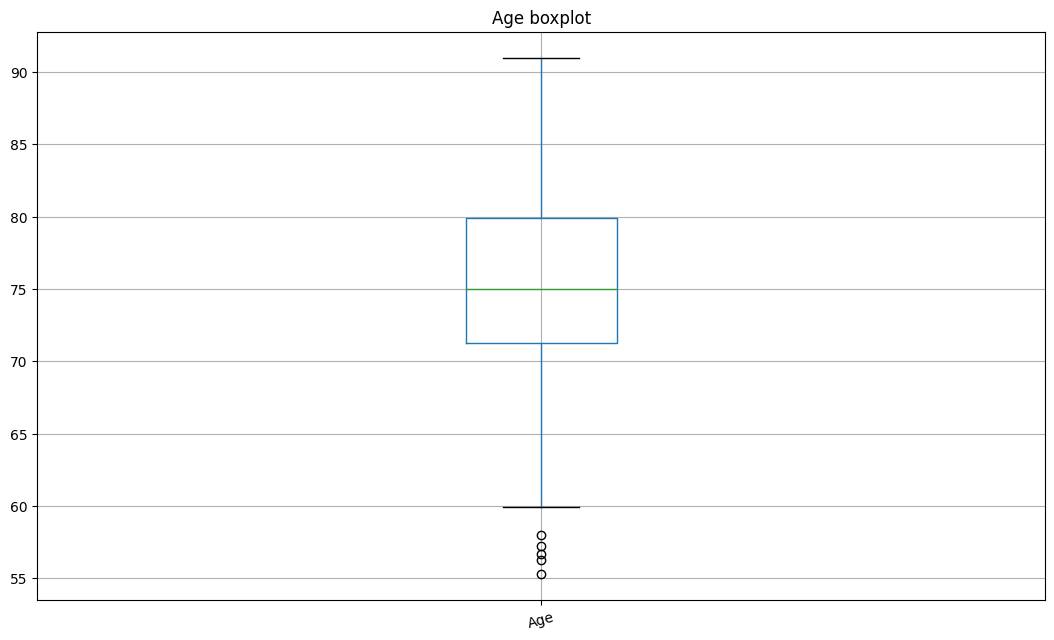

41     55.3
106    57.2
147    56.3
248    58.0
292    56.7
Name: Age, dtype: float64


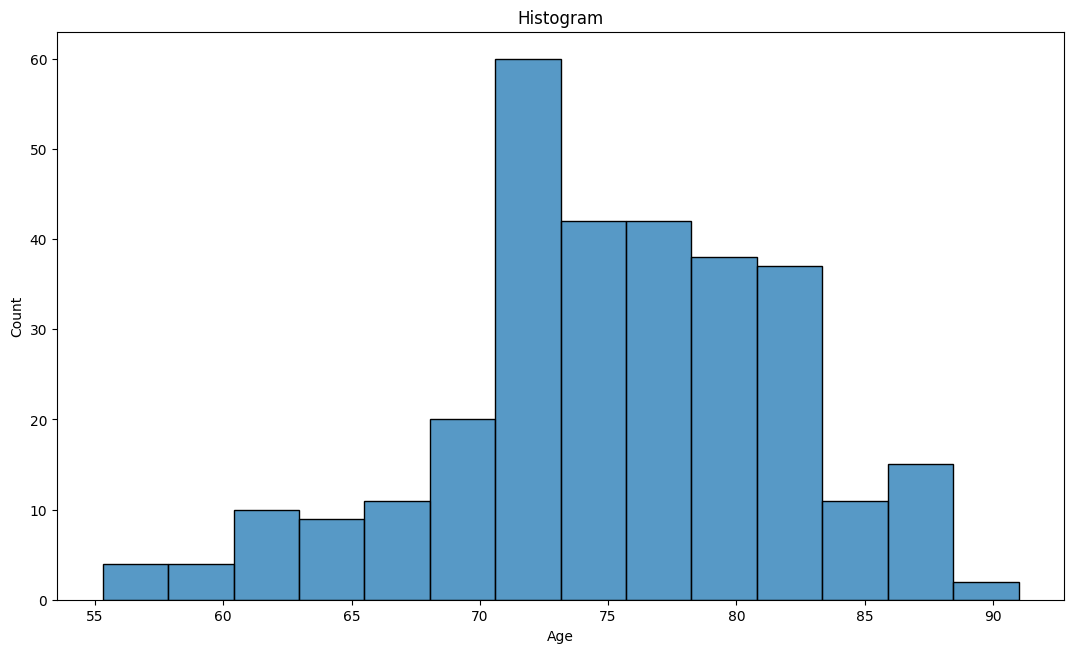

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


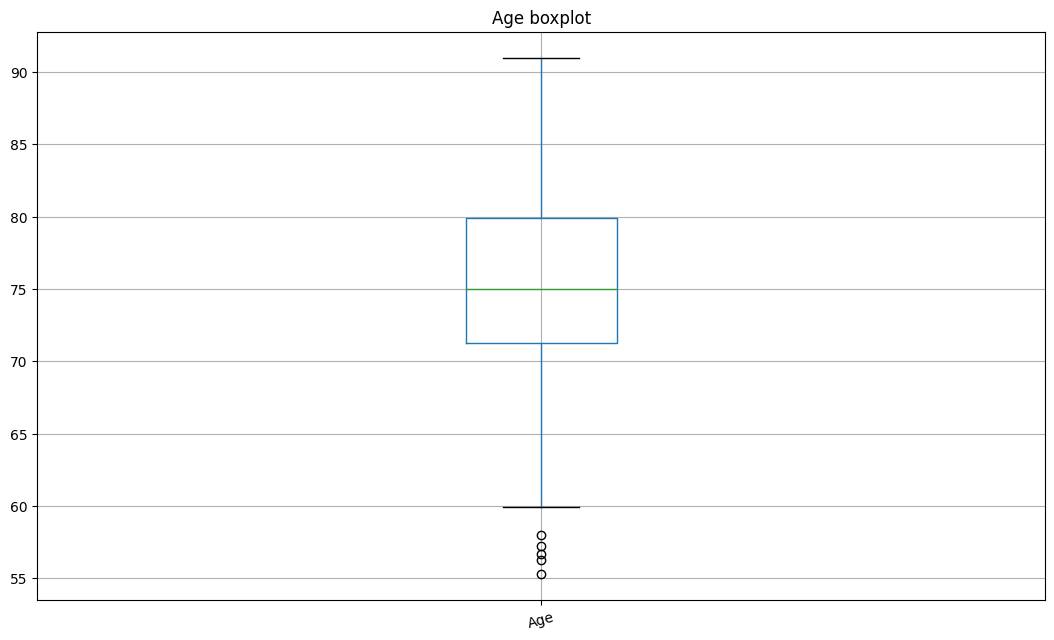

41     55.3
106    57.2
147    56.3
248    58.0
292    56.7
Name: Age, dtype: float64


In [37]:
numerical_exploration(control_df)
numerical_exploration(train_df)

In [38]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())


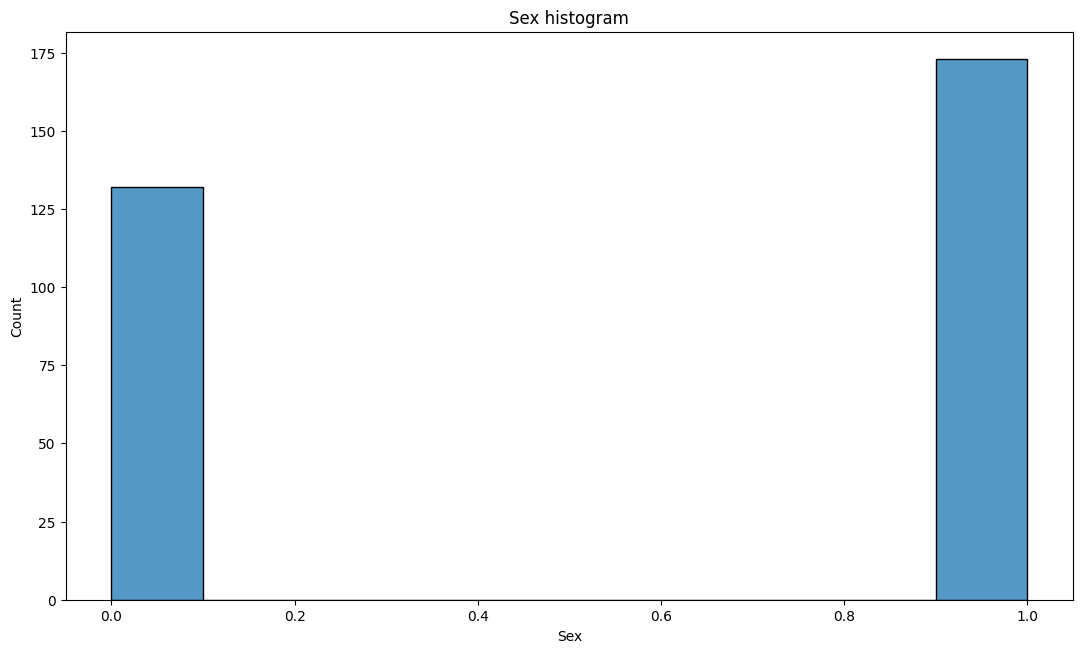

Sex
1    173
0    132
Name: count, dtype: int64


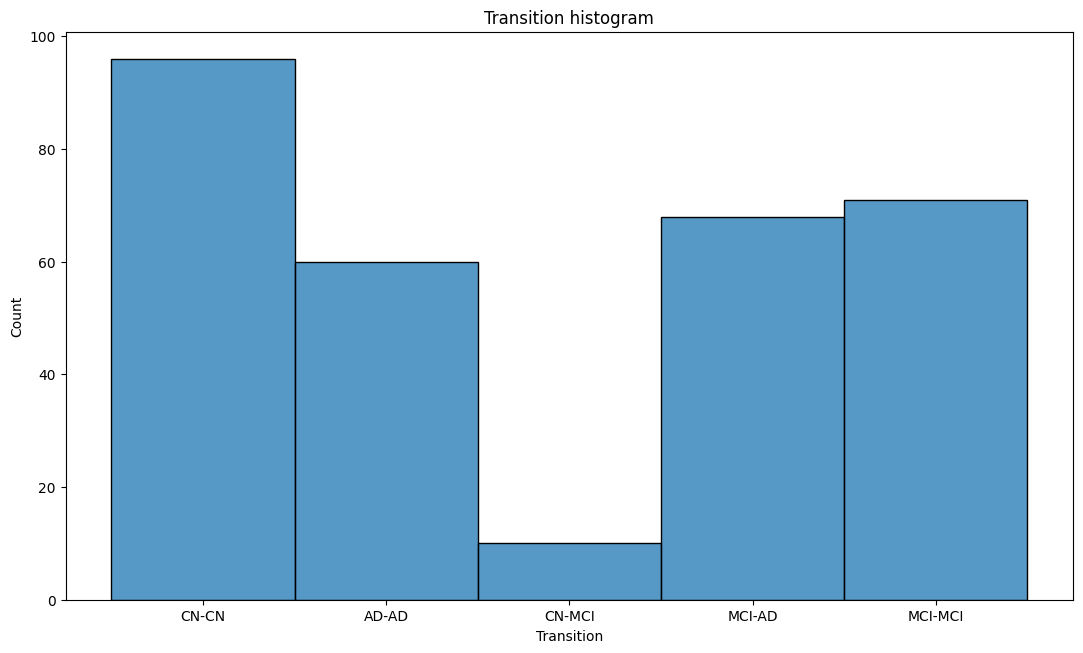

Transition
CN-CN      96
MCI-MCI    71
MCI-AD     68
AD-AD      60
CN-MCI     10
Name: count, dtype: int64


In [39]:
categorical_exploration(train_df)

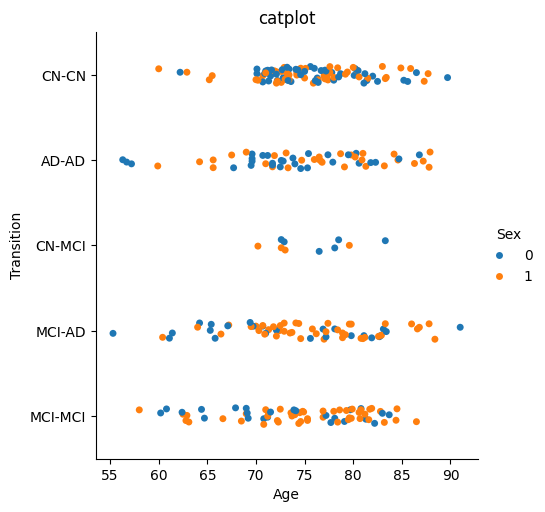

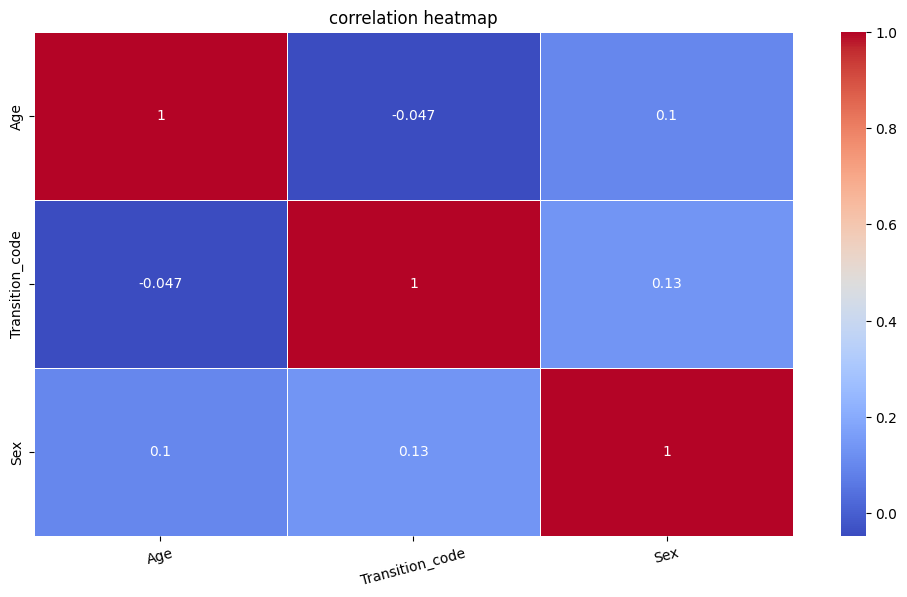

In [40]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

## Diagnostic Exploration

In [26]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [74]:
diagnostics_configs(control_df)
diagnostics_configs(train_df)

1
1
1
1


In [24]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [106]:
diagnostics_versions_explorer(control_df)
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']
diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [17]:
diagnostics_image_columns = ["diagnostics_Image-original_Mean","diagnostics_Image-original_Minimum","diagnostics_Image-original_Maximum"]
def diagnostics_image_explorer(df):

    for column in diagnostics_image_columns:
        show_histogram(df=df[column],title=column)

    explore_outliers(df,diagnostics_image_columns)

    print(df[diagnostics_image_columns].describe())
    print(df[diagnostics_image_columns].info())
    

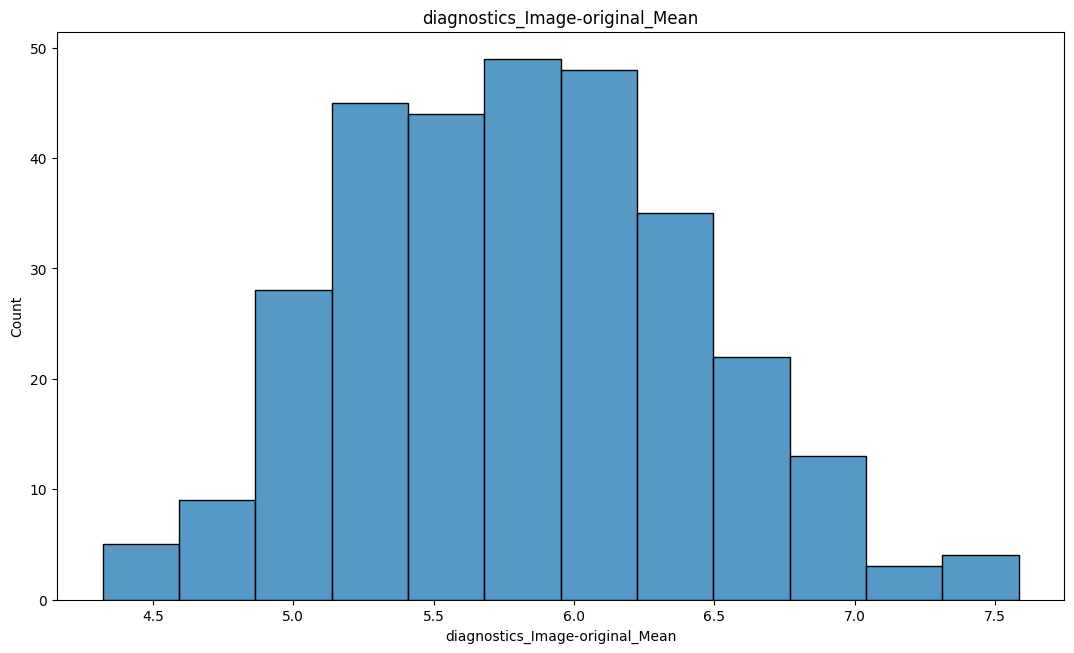

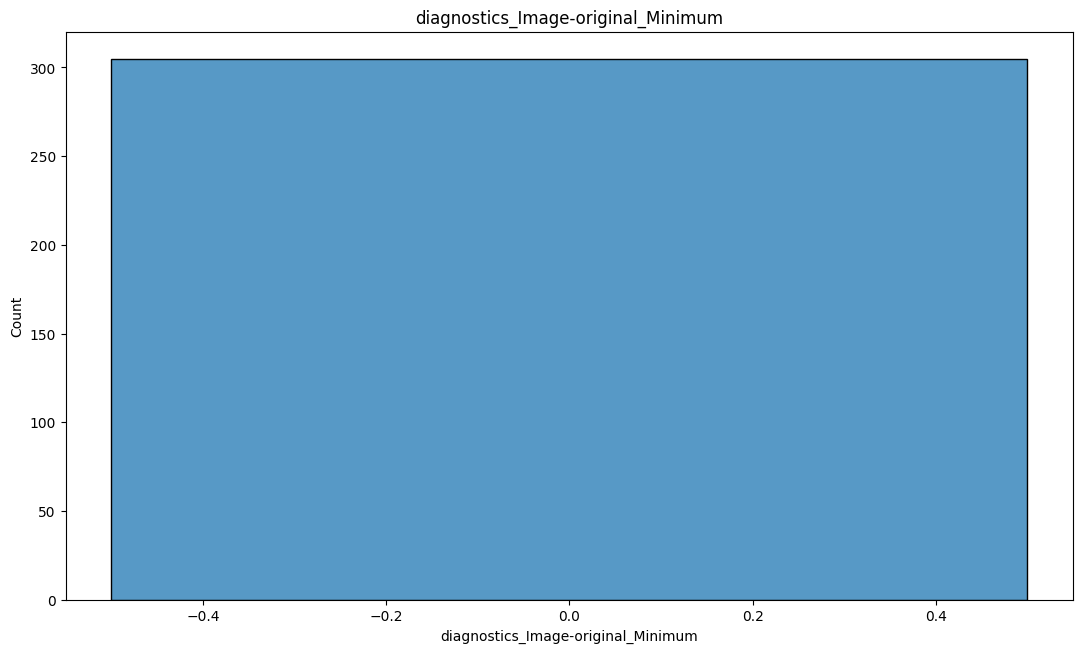

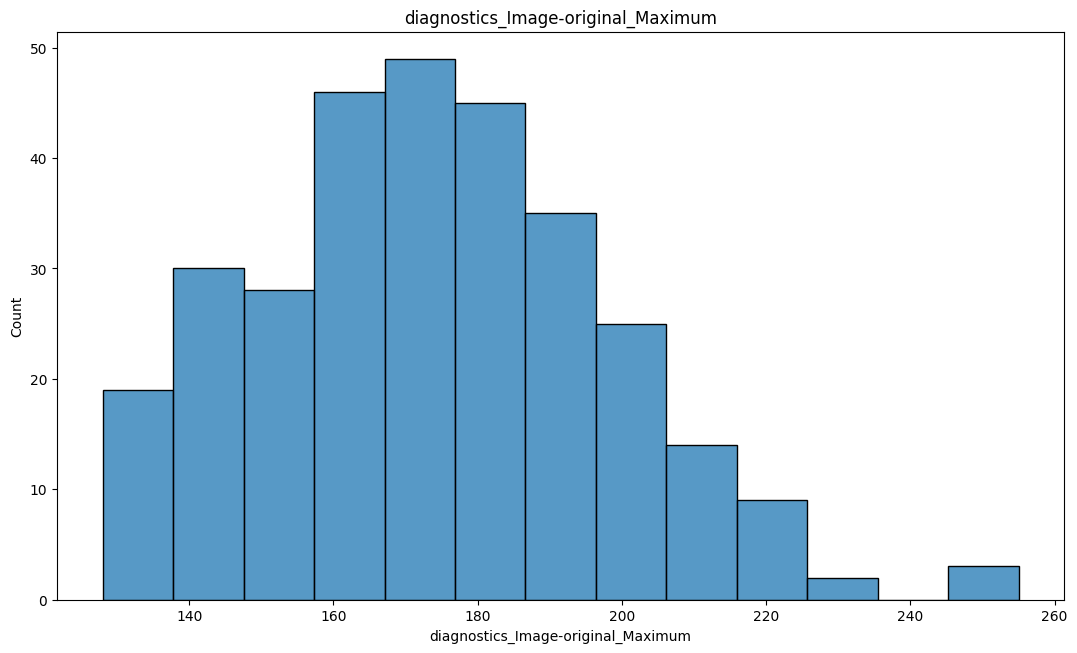

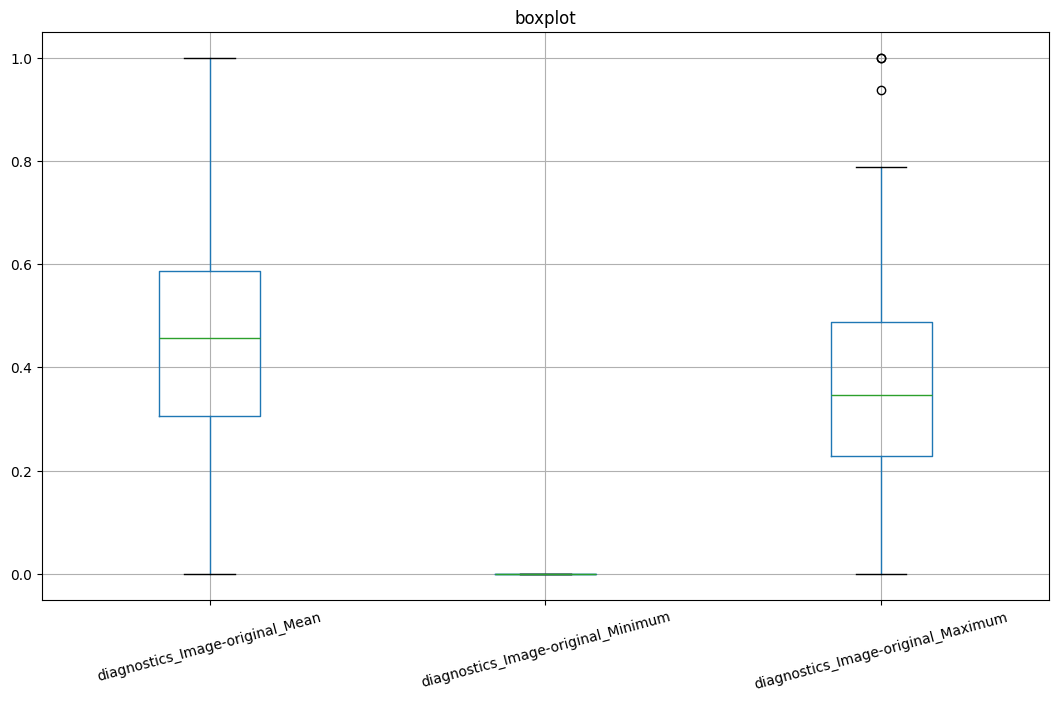

       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                       305.000000                               305.0   
mean                          5.810469                                 0.0   
std                           0.613858                                 0.0   
min                           4.321602                                 0.0   
25%                           5.317298                                 0.0   
50%                           5.811449                                 0.0   
75%                           6.237751                                 0.0   
max                           7.583210                                 0.0   

       diagnostics_Image-original_Maximum  
count                          305.000000  
mean                           173.504918  
std                             24.108871  
min                            128.000000  
25%                            157.000000  
50%                            17

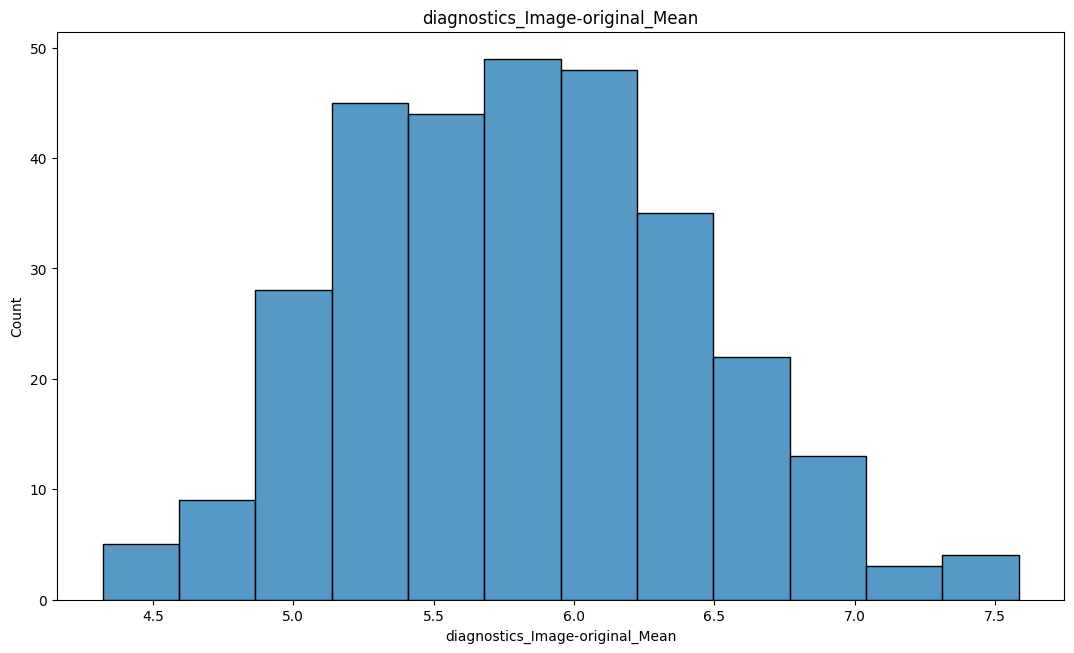

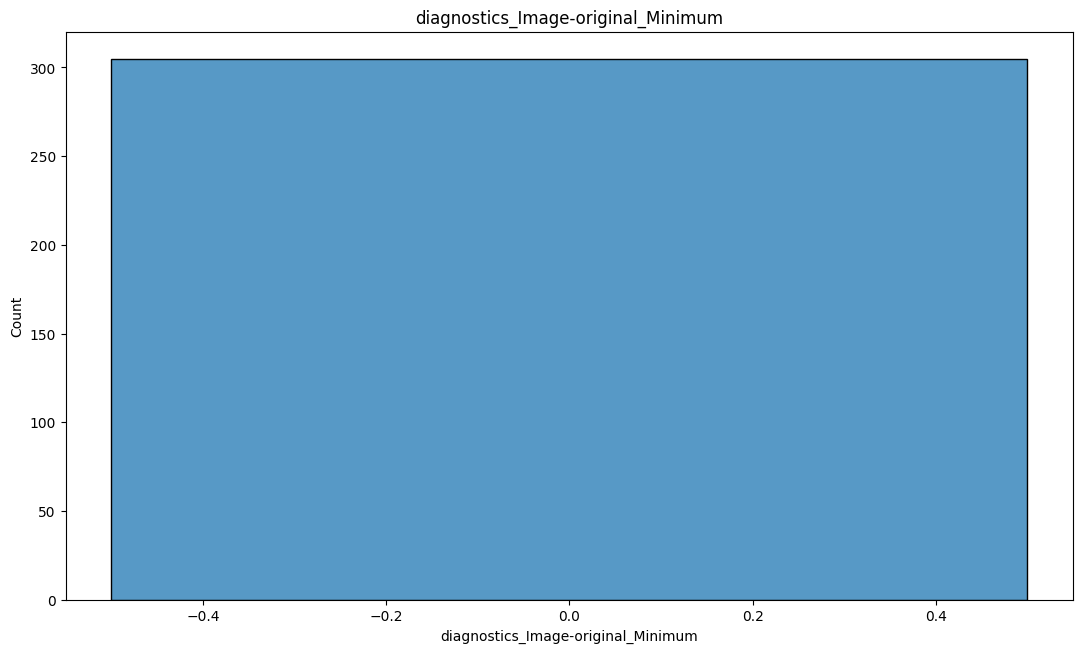

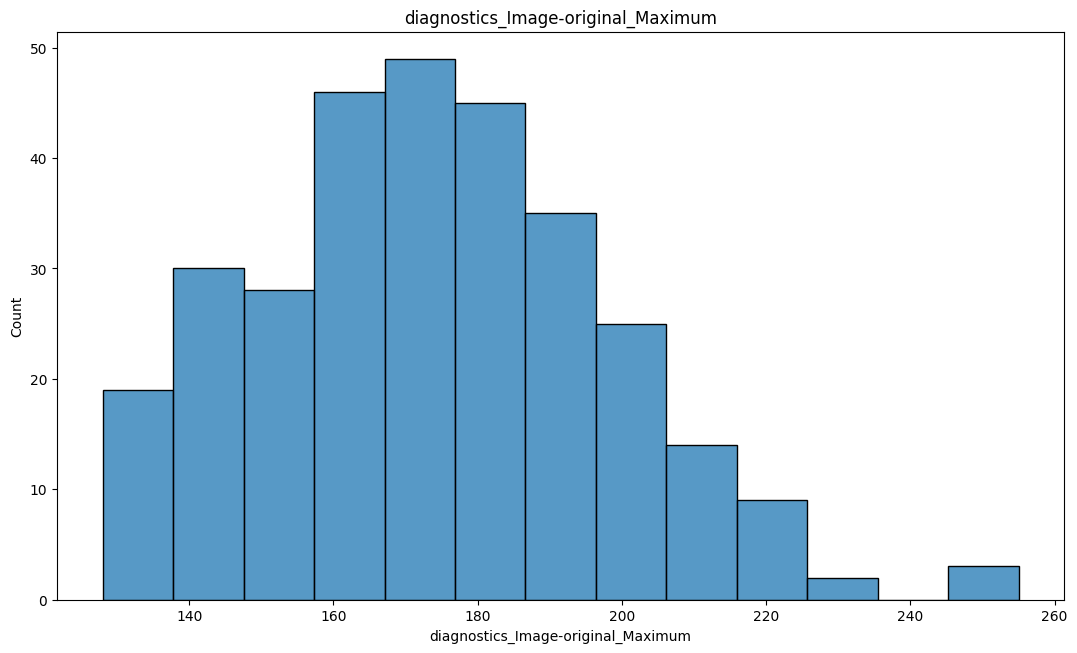

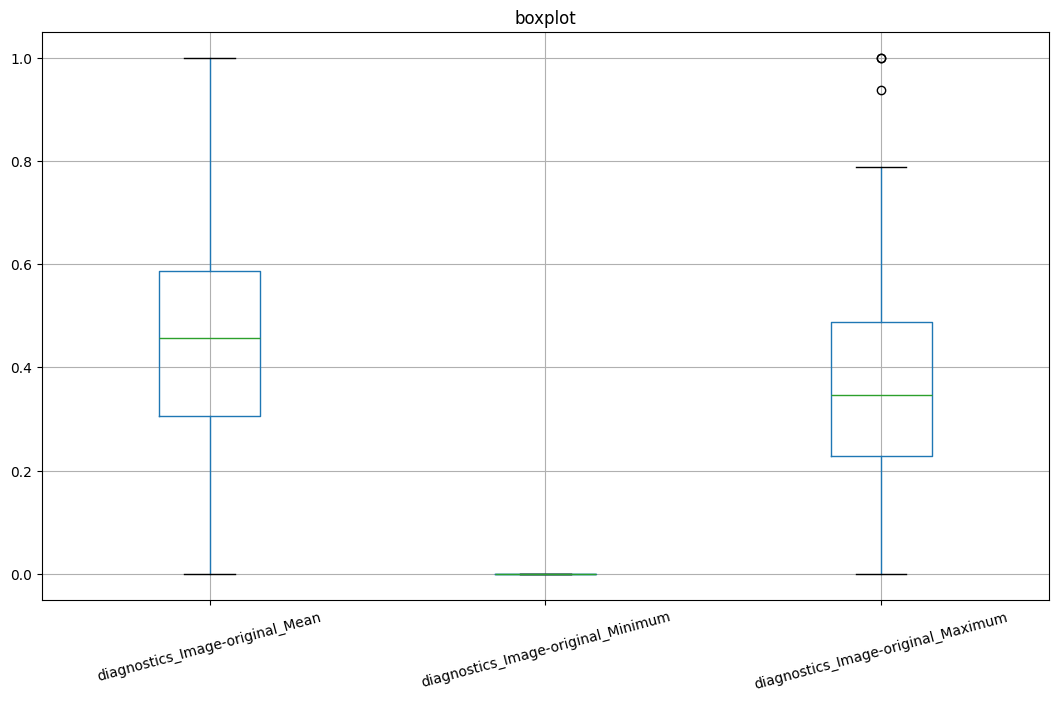

       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                       305.000000                               305.0   
mean                          5.810469                                 0.0   
std                           0.613858                                 0.0   
min                           4.321602                                 0.0   
25%                           5.317298                                 0.0   
50%                           5.811449                                 0.0   
75%                           6.237751                                 0.0   
max                           7.583210                                 0.0   

       diagnostics_Image-original_Maximum  
count                          305.000000  
mean                           173.504918  
std                             24.108871  
min                            128.000000  
25%                            157.000000  
50%                            17

In [62]:
diagnostics_image_explorer(control_df)
diagnostics_image_explorer(train_df)

In [128]:
diagnostics_mask_columns = ["diagnostics_Mask-original_BoundingBox","diagnostics_Mask-original_VoxelNum","diagnostics_Mask-original_VolumeNum","diagnostics_Mask-original_CenterOfMassIndex","diagnostics_Mask-original_CenterOfMass"]
def diagnostics_mask_explorer(df):

    
    for column in diagnostics_mask_columns:
        print(column,": ")
        values = df[column].unique()
        print(len(values))
        show_histogram(title=column,df=df[column])
    

    detect_outliers(df,"diagnostics_Mask-original_VoxelNum")
    detect_outliers(df,"diagnostics_Mask-original_VolumeNum")
    explore_outliers(df,columns=diagnostics_mask_columns)
    
    print(df[diagnostics_mask_columns].describe(),"\n")
    print(df[diagnostics_mask_columns].info())

diagnostics_Mask-original_BoundingBox : 
305


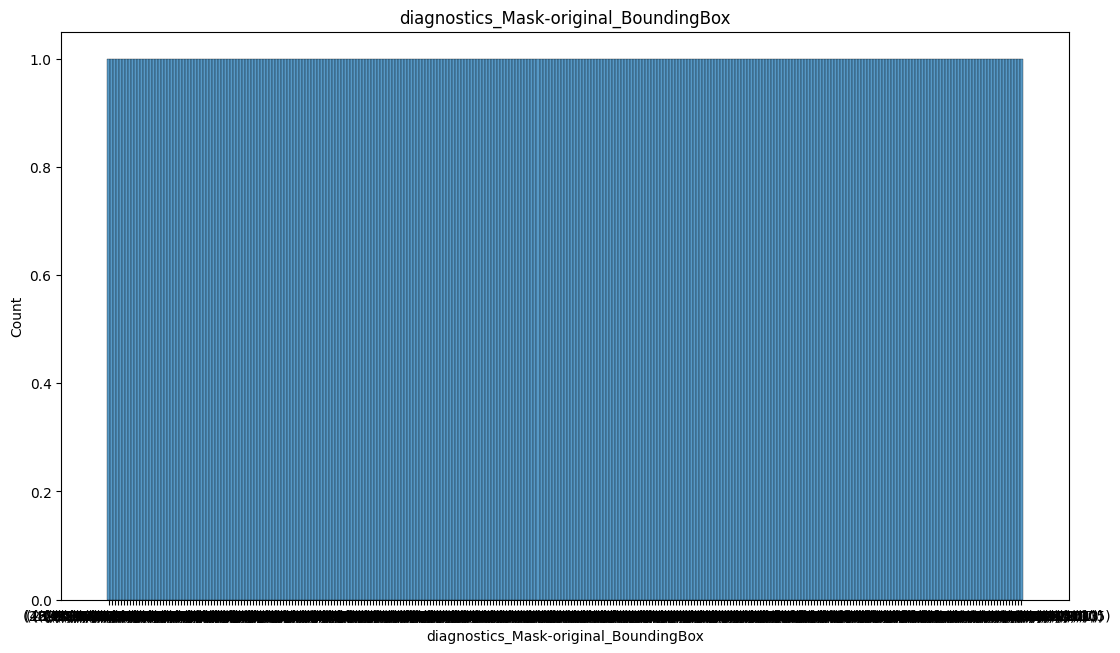

diagnostics_Mask-original_VoxelNum : 
300


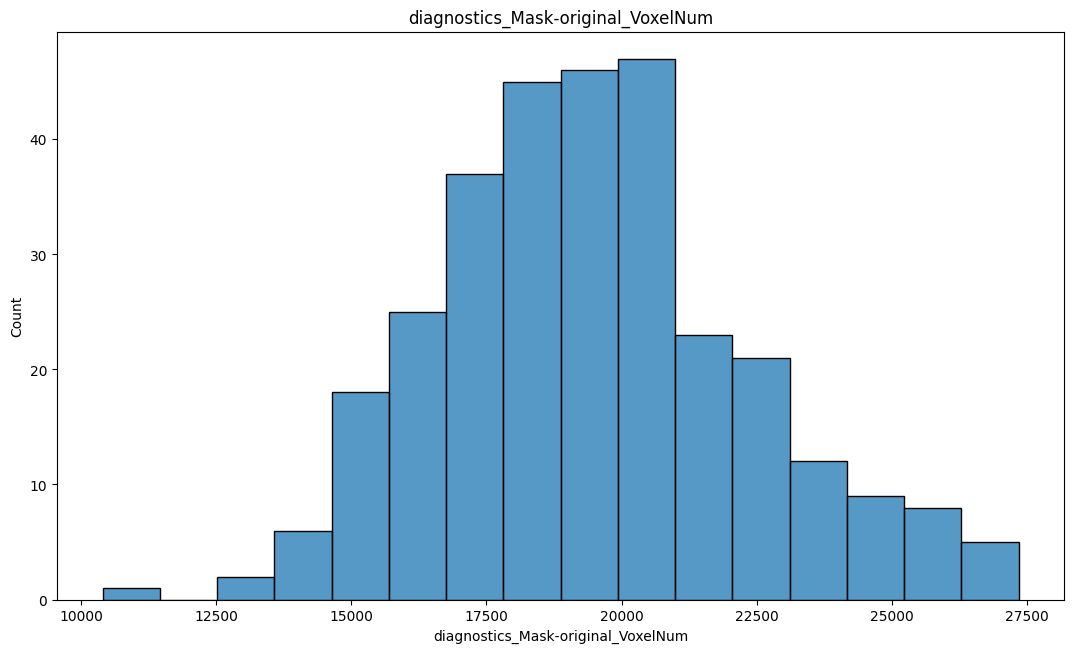

diagnostics_Mask-original_VolumeNum : 
4


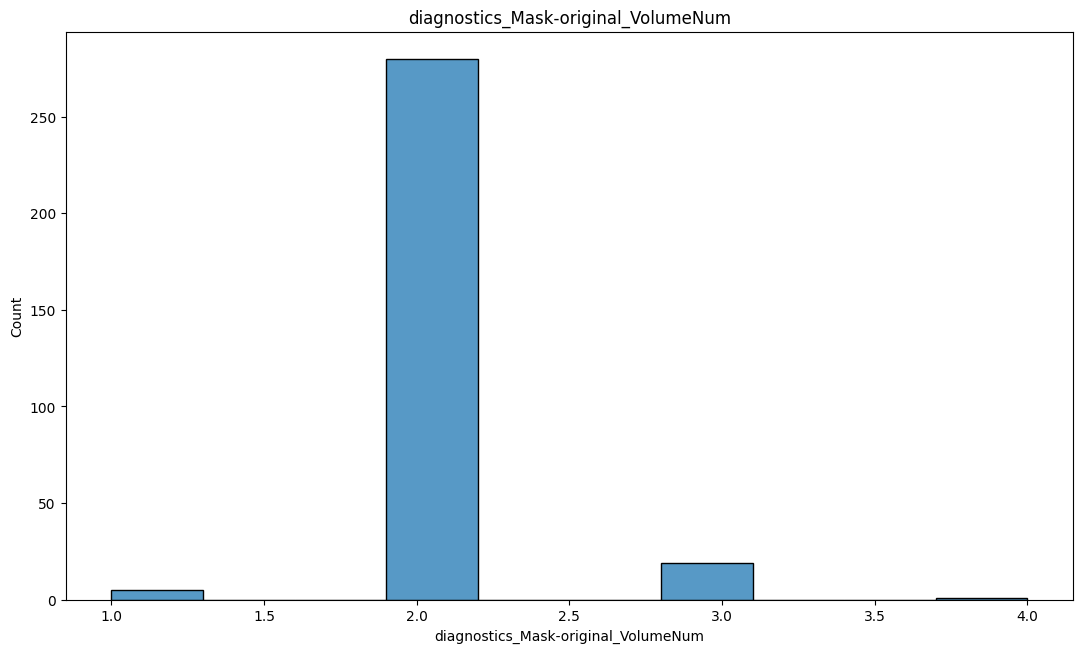

diagnostics_Mask-original_CenterOfMassIndex : 
305


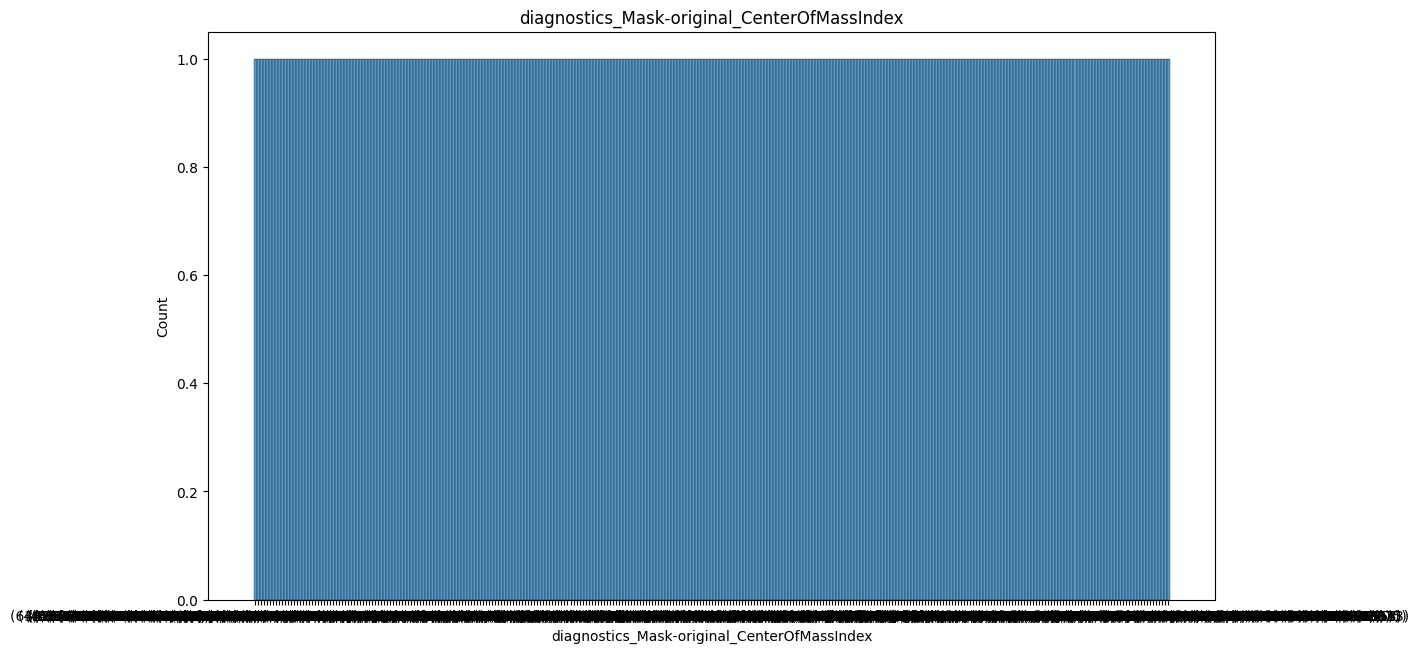

diagnostics_Mask-original_CenterOfMass : 
305


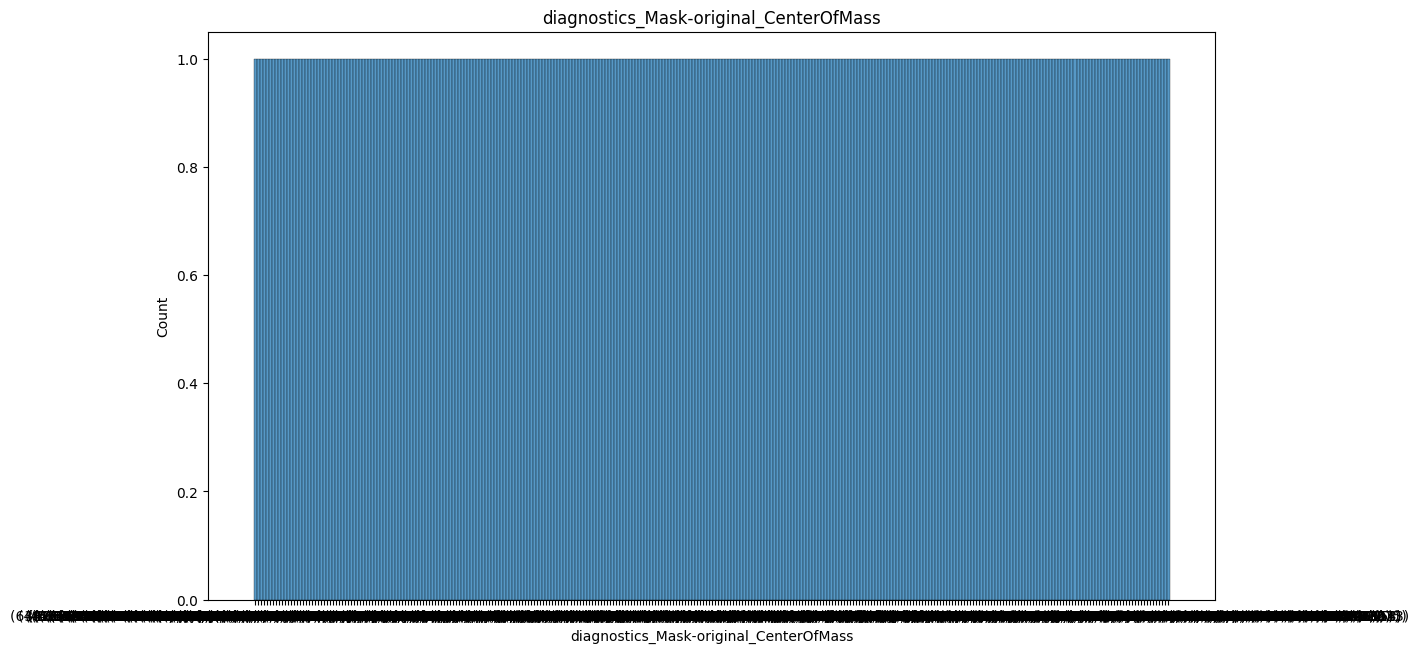

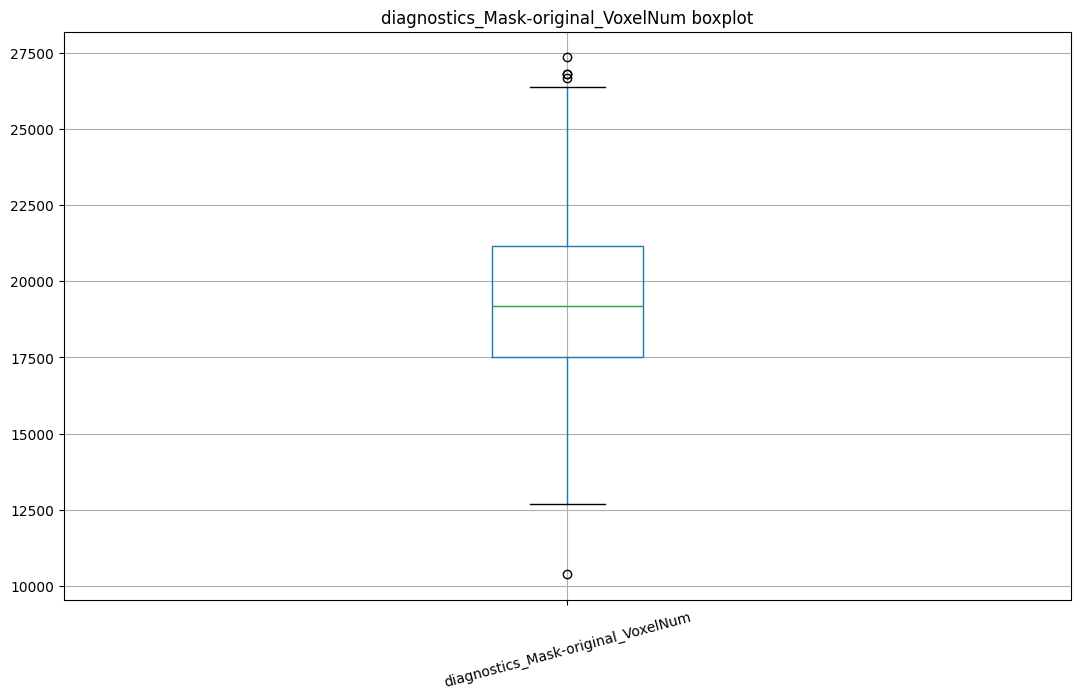

58     26802
109    26668
153    27345
156    26813
174    10400
Name: diagnostics_Mask-original_VoxelNum, dtype: int64


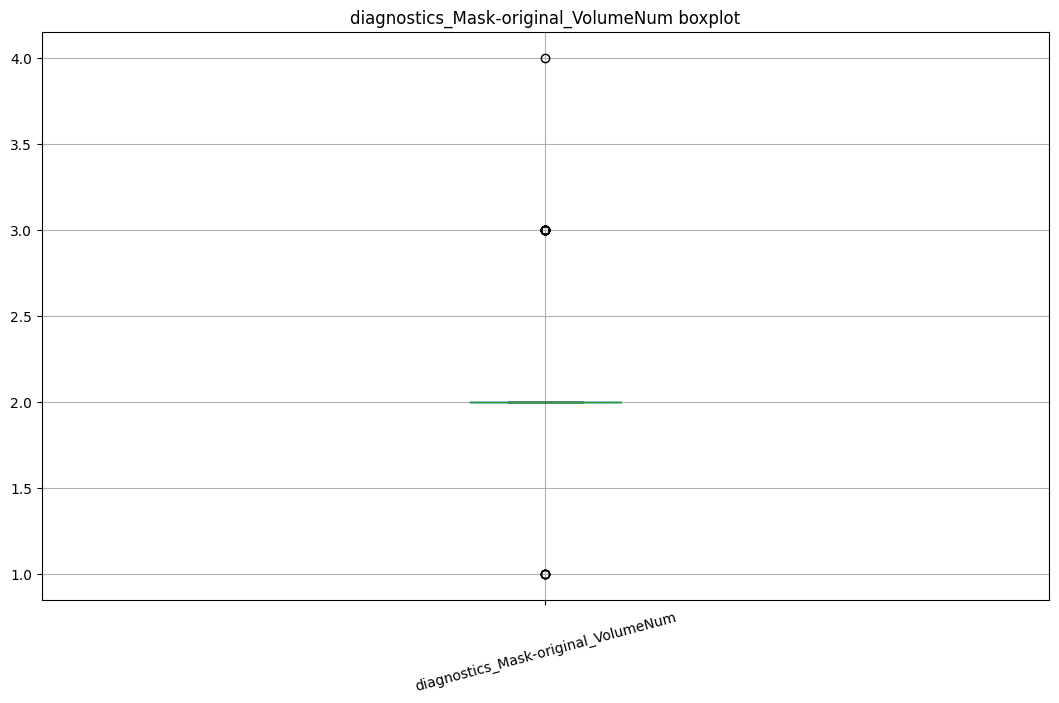

2      4
28     3
38     3
41     3
45     3
59     3
73     1
83     1
89     3
98     3
101    3
112    3
114    1
131    3
141    3
144    1
147    1
148    3
151    3
163    3
230    3
244    3
262    3
274    3
298    3
Name: diagnostics_Mask-original_VolumeNum, dtype: int64


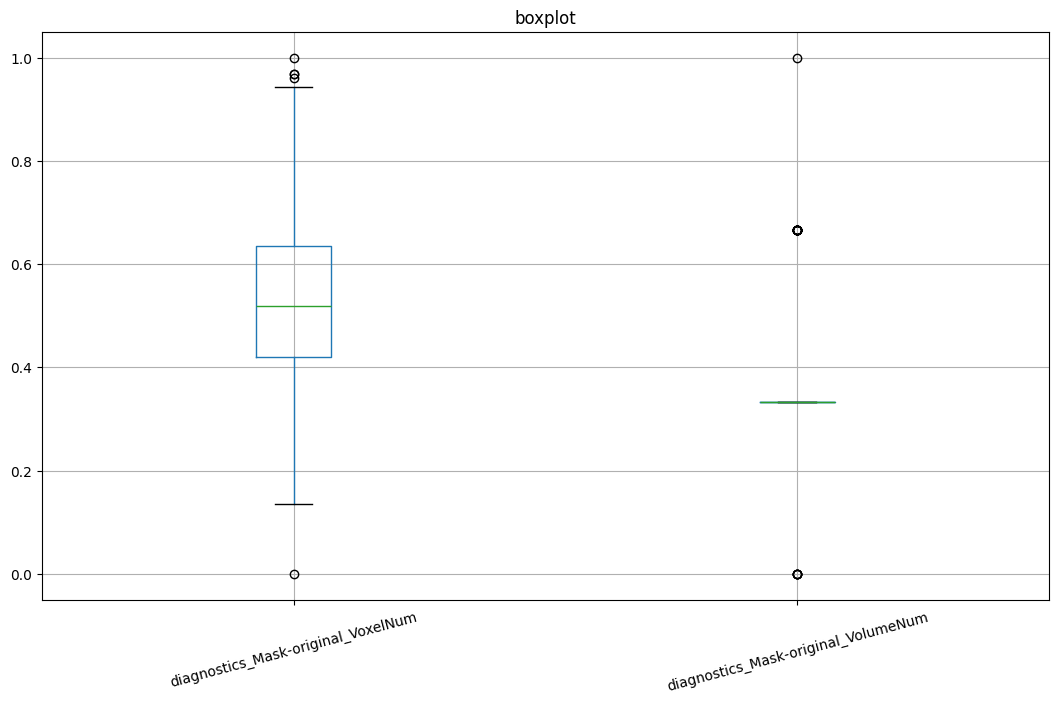

       diagnostics_Mask-original_VoxelNum  diagnostics_Mask-original_VolumeNum
count                          305.000000                           305.000000
mean                         19466.340984                             2.052459
std                           2897.483977                             0.298905
min                          10400.000000                             1.000000
25%                          17521.000000                             2.000000
50%                          19201.000000                             2.000000
75%                          21155.000000                             2.000000
max                          27345.000000                             4.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   diagnostics_Mask-original_Boundi

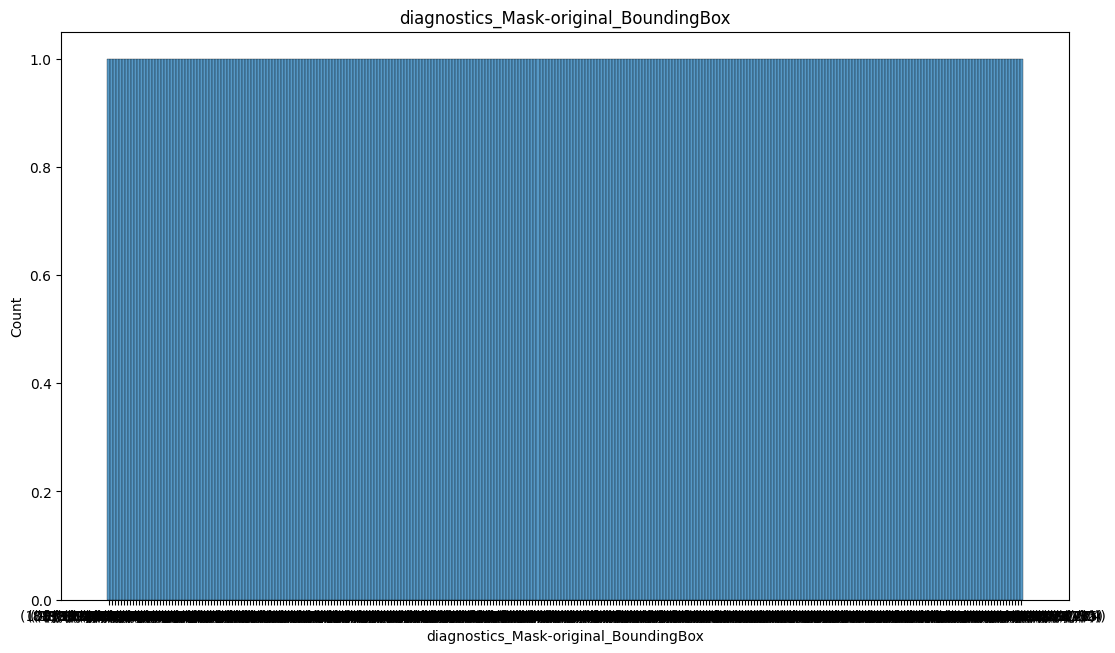

diagnostics_Mask-original_VoxelNum : 
294


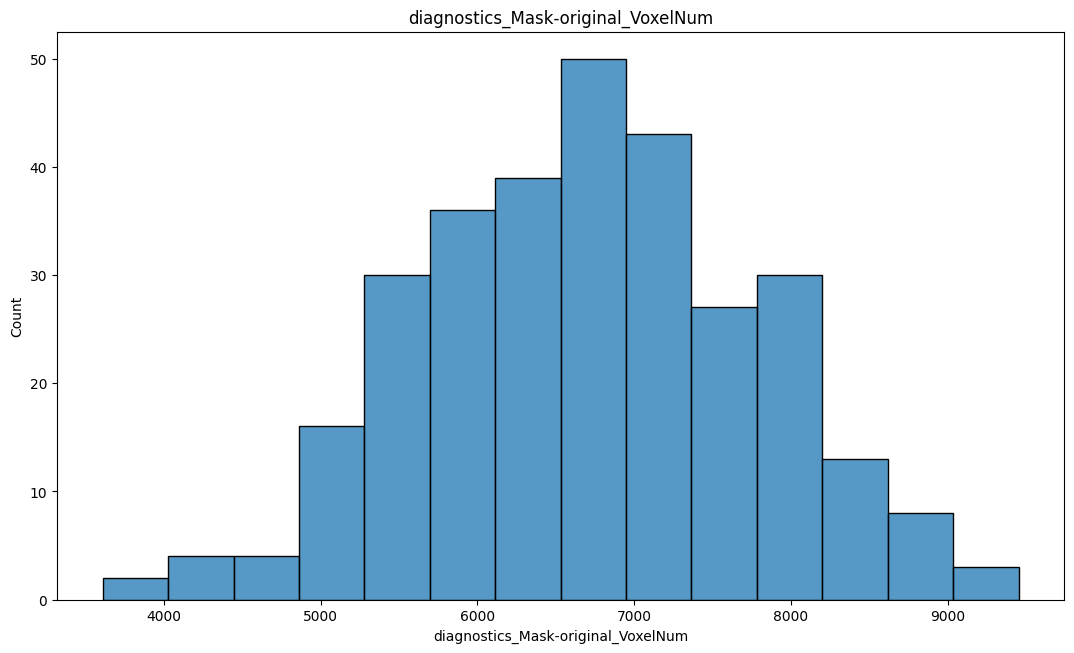

diagnostics_Mask-original_VolumeNum : 
1


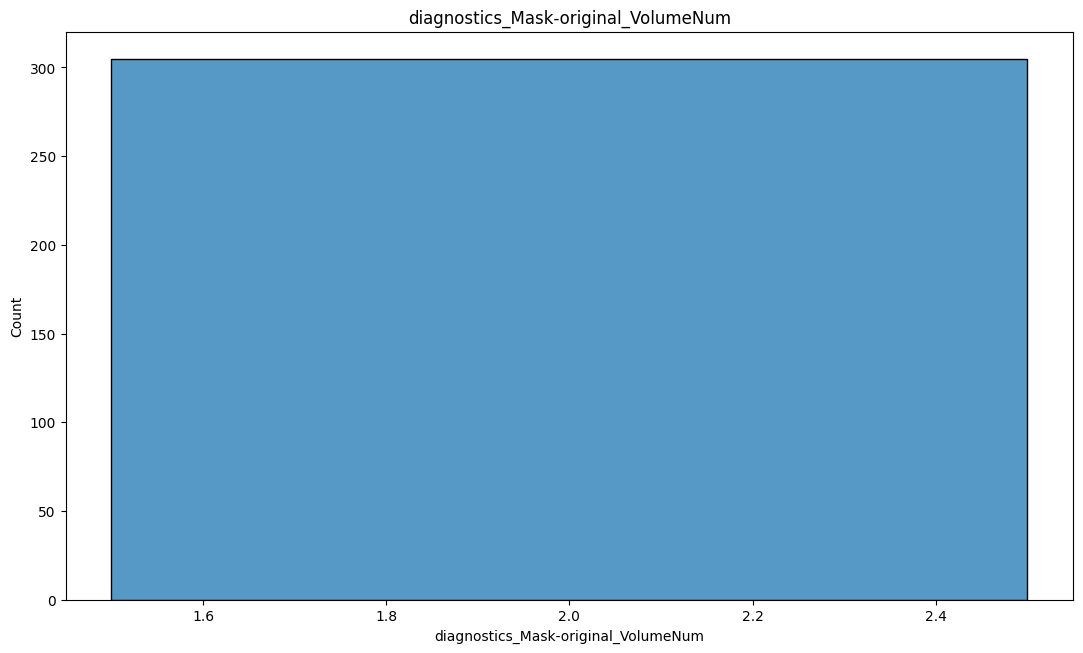

diagnostics_Mask-original_CenterOfMassIndex : 
305


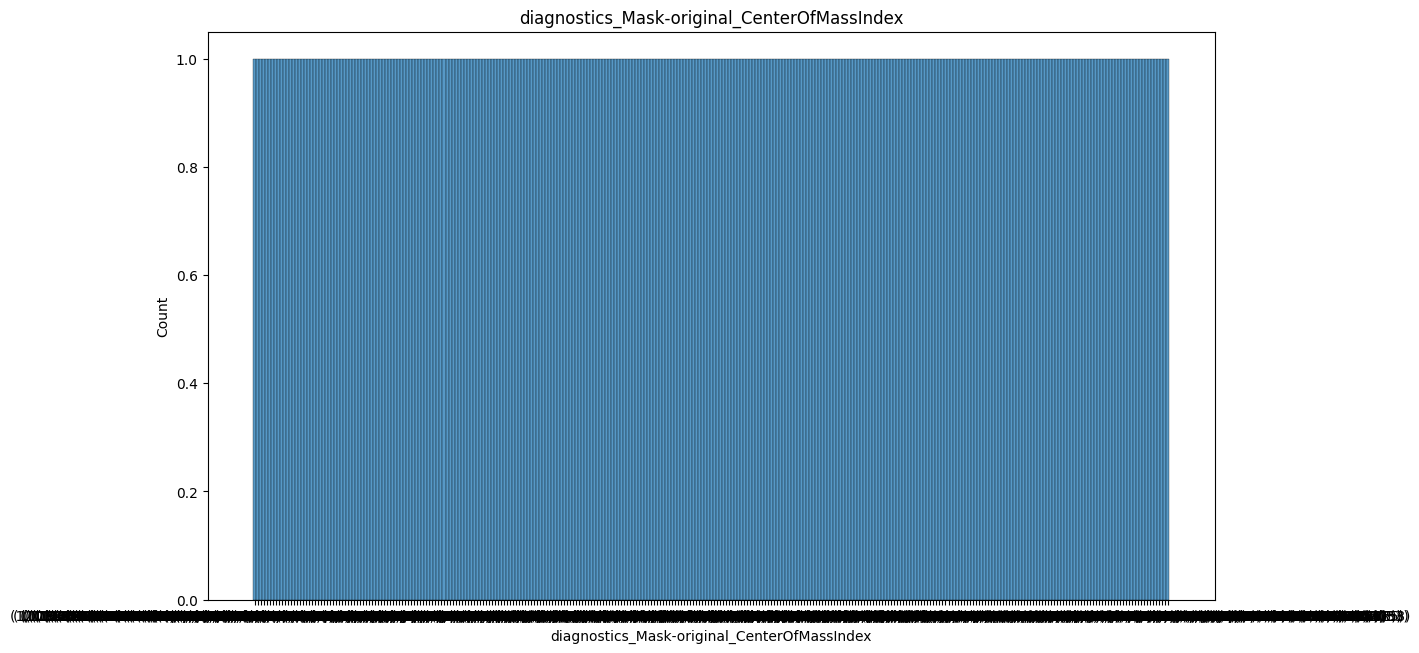

diagnostics_Mask-original_CenterOfMass : 
305


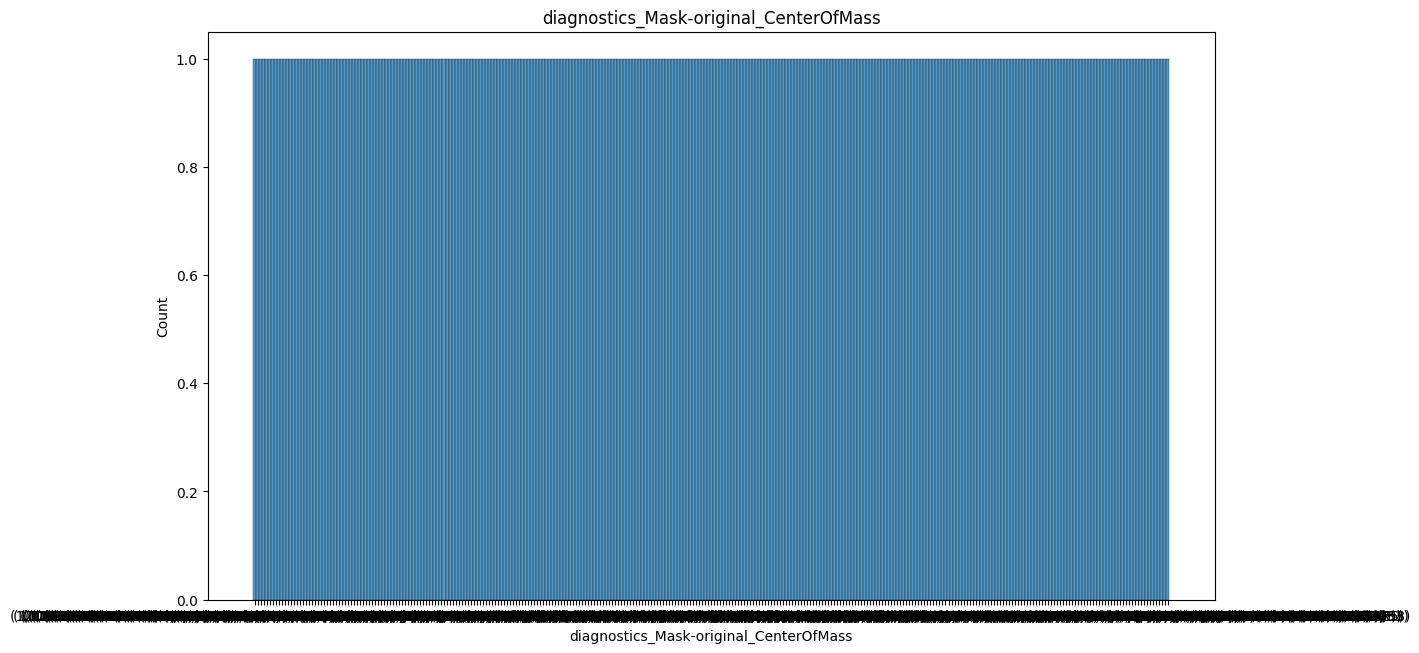

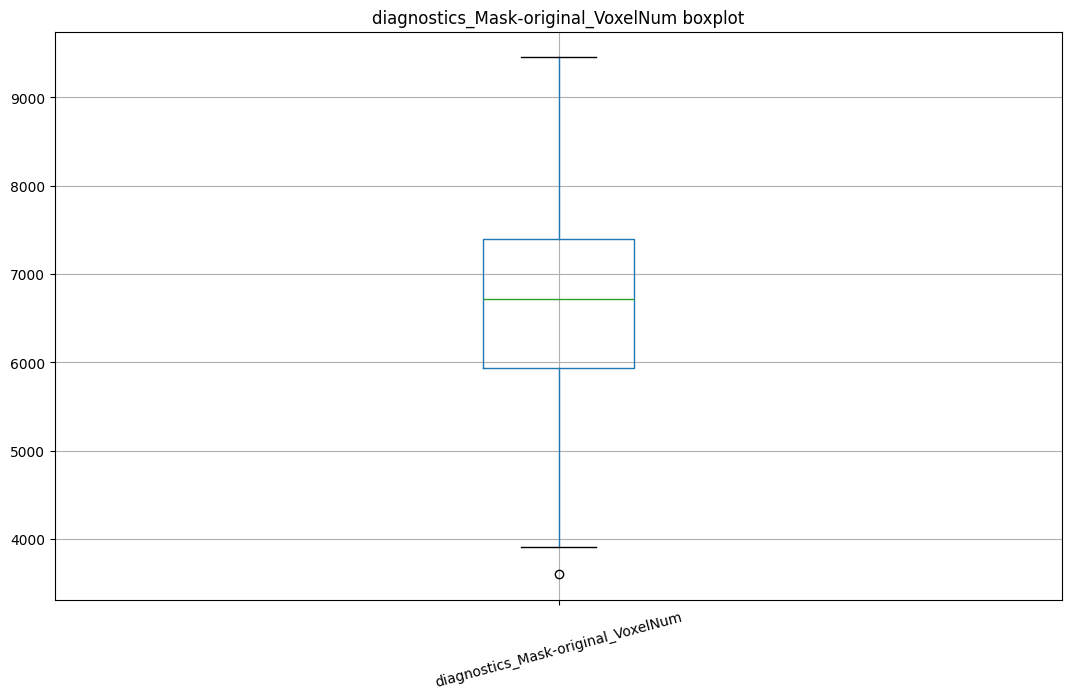

188    3609
Name: diagnostics_Mask-original_VoxelNum, dtype: int64


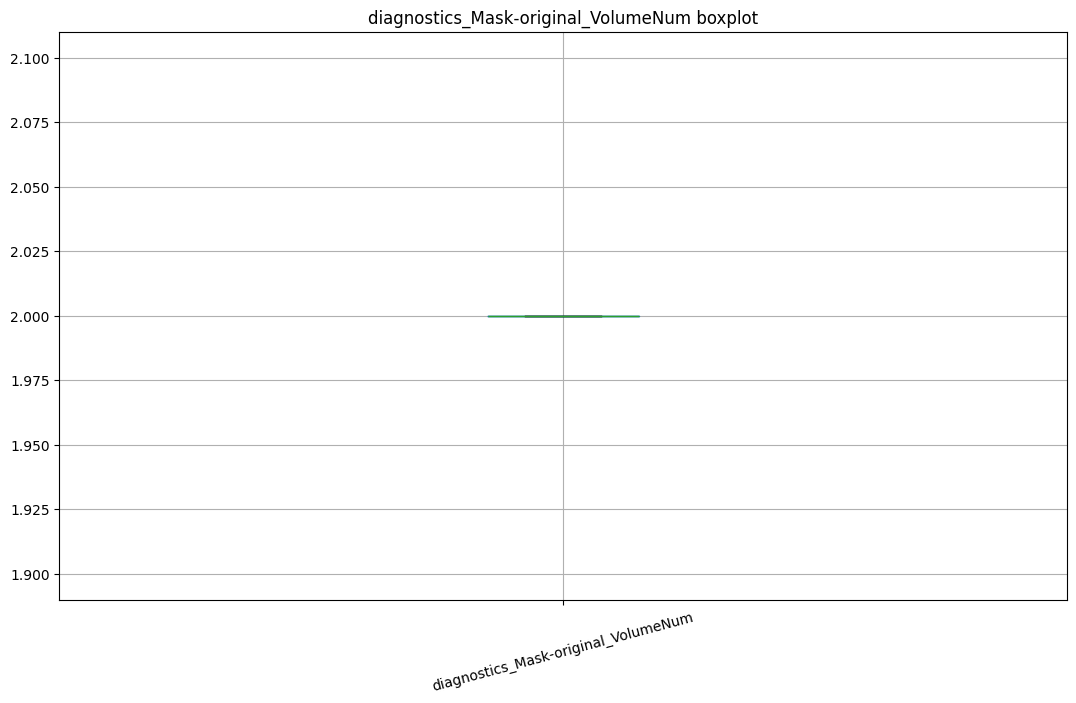

Series([], Name: diagnostics_Mask-original_VolumeNum, dtype: int64)


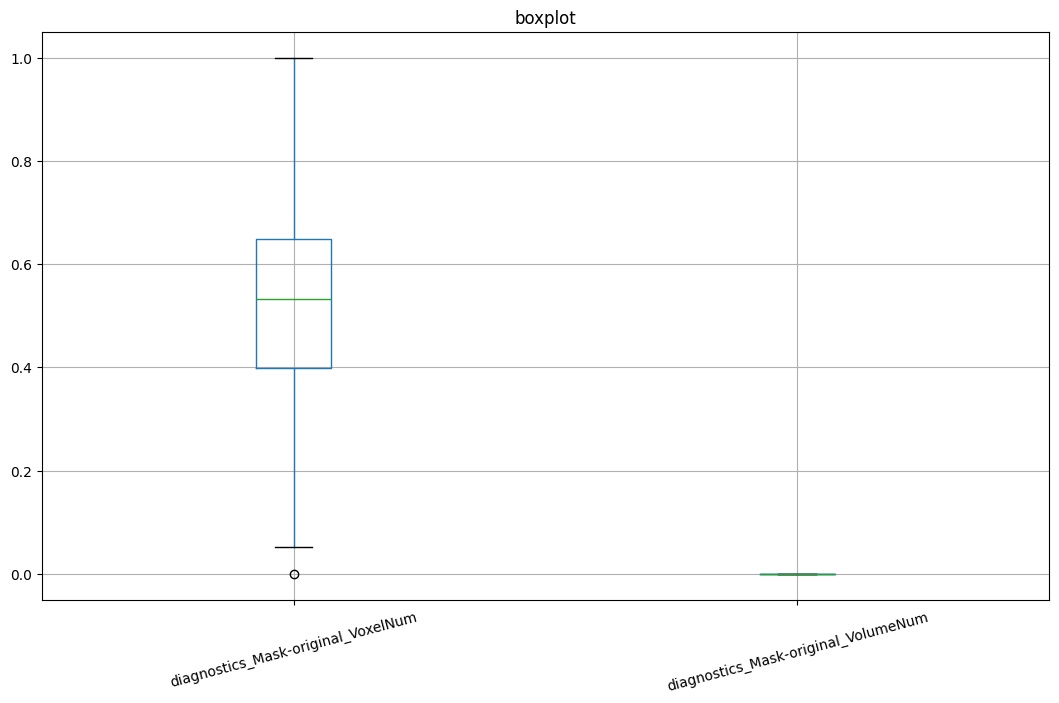

       diagnostics_Mask-original_VoxelNum  diagnostics_Mask-original_VolumeNum
count                          305.000000                                305.0
mean                          6714.790164                                  2.0
std                           1066.815670                                  0.0
min                           3609.000000                                  2.0
25%                           5941.000000                                  2.0
50%                           6723.000000                                  2.0
75%                           7396.000000                                  2.0
max                           9453.000000                                  2.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   diagnostics_Mask-original_Boundi

In [129]:
diagnostics_mask_explorer(control_df)
diagnostics_mask_explorer(train_df)

In [21]:
diagnostics = ["diagnostics_Mask-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Mask-original_BoundingBox","diagnostics_Mask-original_VoxelNum","diagnostics_Mask-original_VolumeNum","diagnostics_Mask-original_CenterOfMassIndex","diagnostics_Mask-original_CenterOfMass","diagnostics_Image-original_Spacing","diagnostics_Image-original_Size","diagnostics_Image-original_Mean","diagnostics_Image-original_Maximum"]
def masks_images_correlation(df):
    show_heatmap(df=df[diagnostics])   

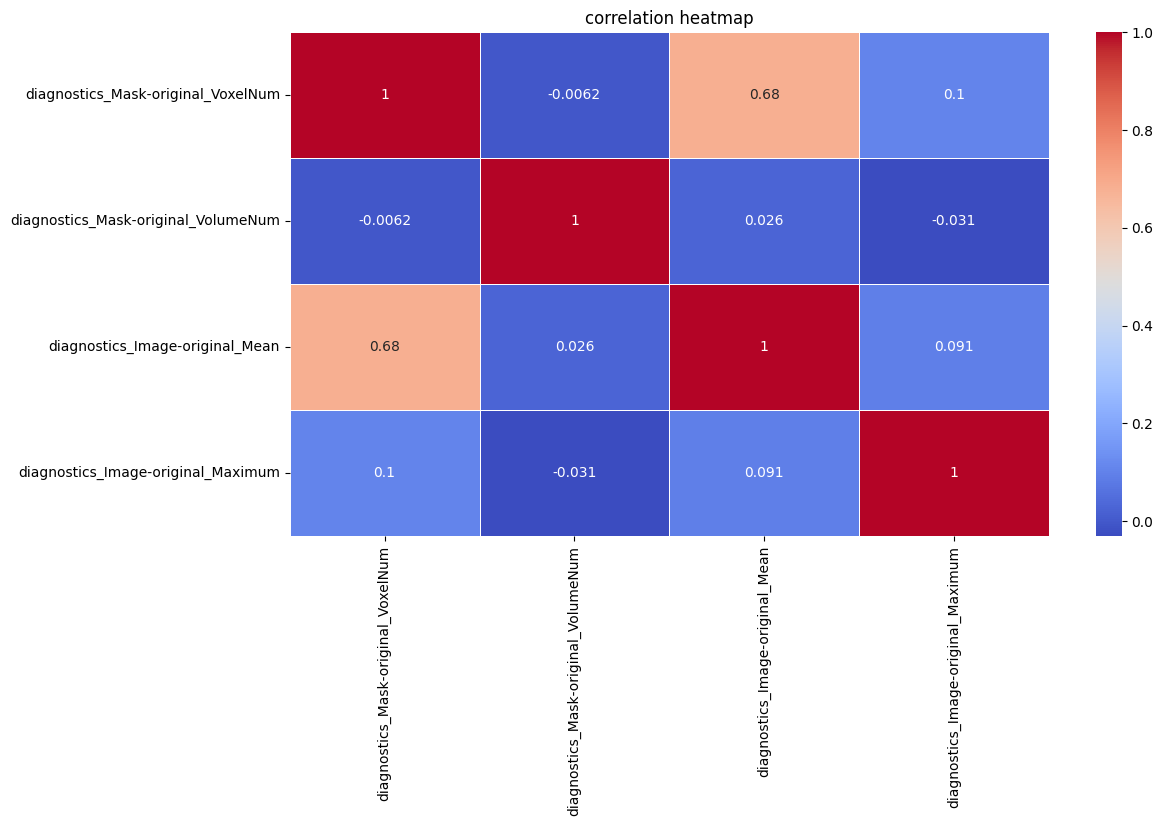

In [22]:
masks_images_correlation(control_df)

## Non Numeric Exploration

In [52]:
def non_numeric_exploration(df):
    non_numeric_columns = train_df.select_dtypes(exclude=['int64', 'float64']).columns
    return non_numeric_columns

In [95]:
non_numeric_columns = non_numeric_exploration(train_df)

print(train_df[non_numeric_columns].head())

  Transition  Transition_code
0      CN-CN                1
1      CN-CN                1
2      AD-AD                0
3     CN-MCI                2
4      CN-CN                1


## Numeric Diagnostics Corr

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


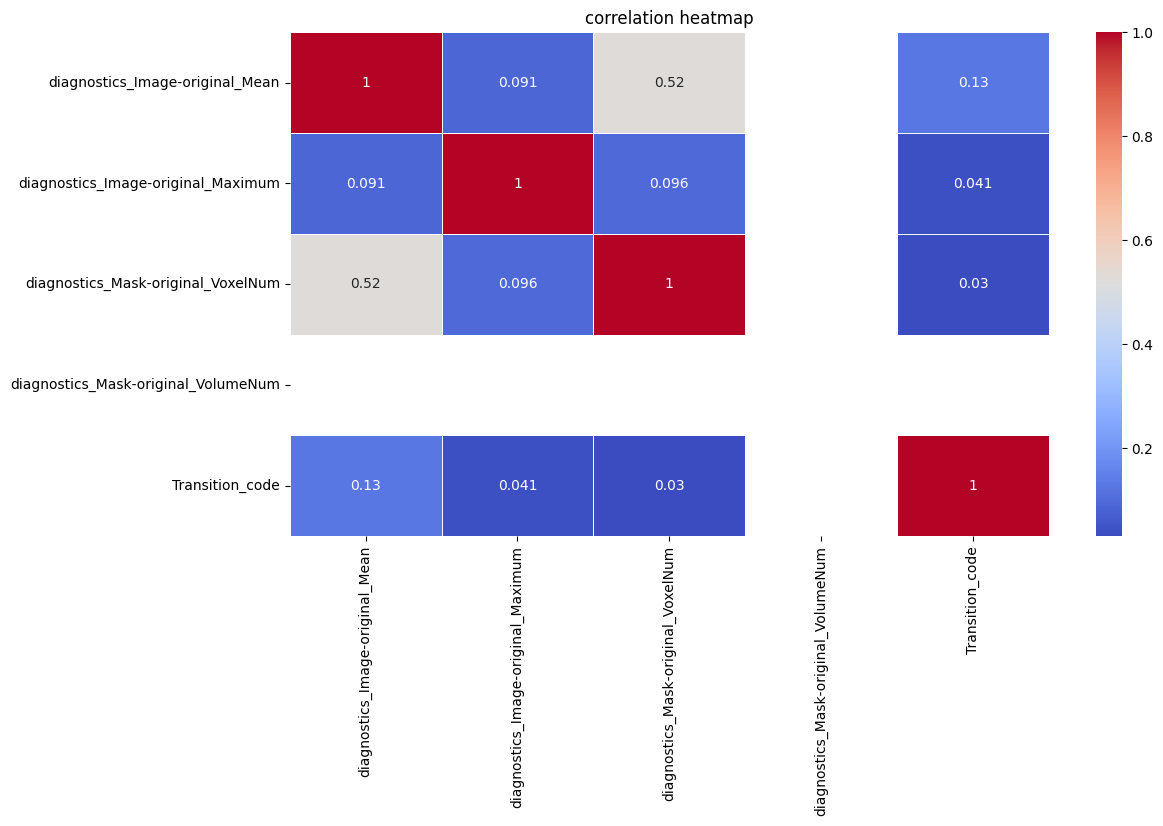

In [74]:
diagnositc_num = train_df.select_dtypes(include=['int64', 'float64']).columns
diagnostics_corr = train_df.columns[train_df.columns.str.startswith('diagnostics')]
common = diagnositc_num.intersection(diagnostics_corr).tolist()
common.append("Transition_code")
common = pd.Index(common)
correlation_matrix = train_df[common].corrwith(train_df["Transition_code"]).index.tolist()

show_heatmap(train_df[correlation_matrix])

## Radiomics

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


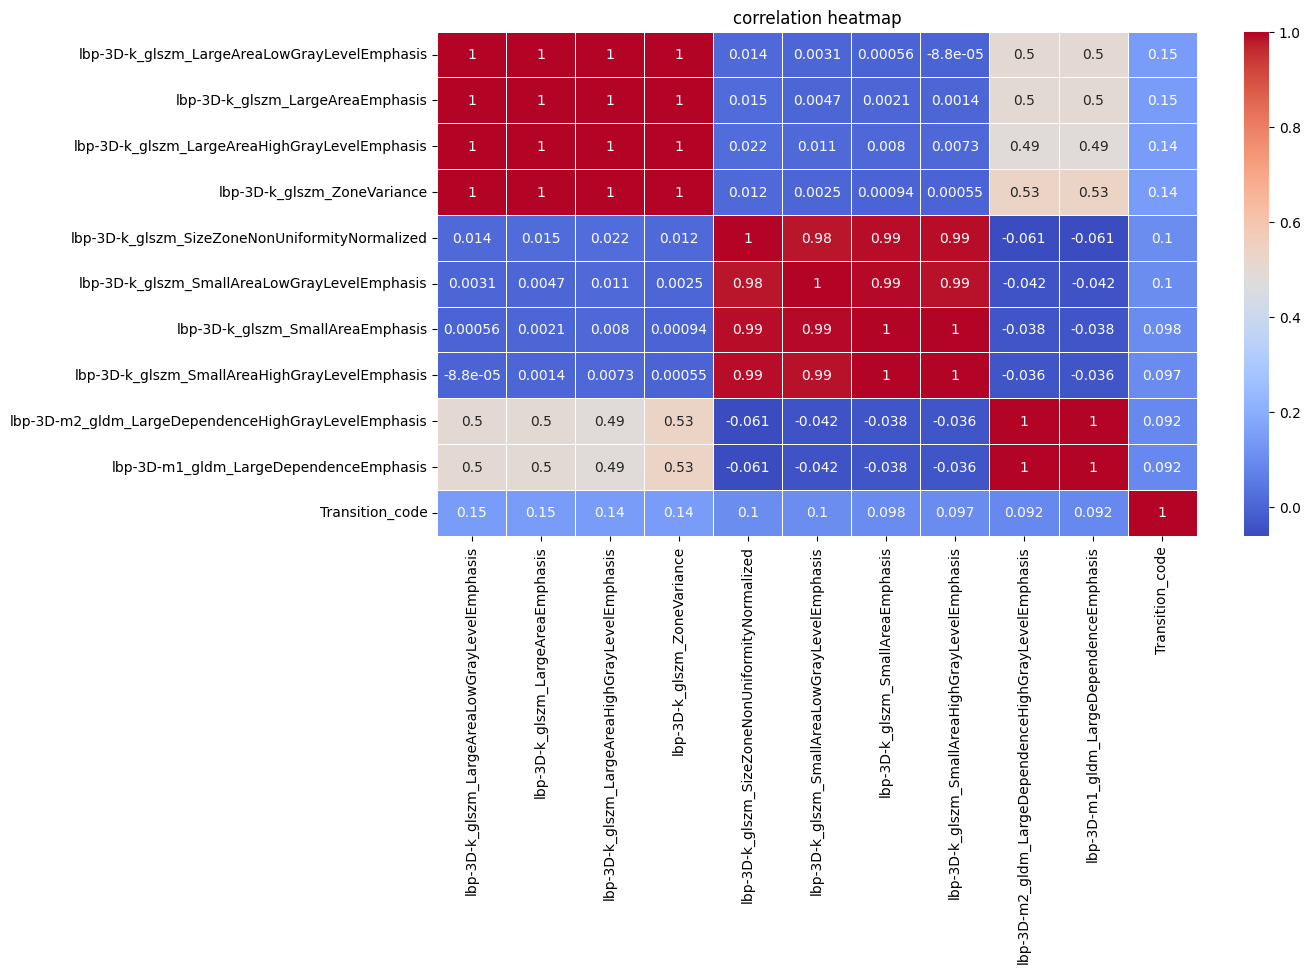

In [152]:
radiomics_features = train_df.columns[train_df.columns.str.startswith('lbp')]
correlation_matrix = train_df[radiomics_features].corrwith(train_df["Transition_code"])

top_features = correlation_matrix.sort_values(ascending=False).head(10).index.tolist()
top_features.append("Transition_code")
top_features = pd.Index(top_features)

show_heatmap(train_df[top_features])

## Top Correlations
Retorna as X colunas com melhor correlação com o nosso target

In [65]:
features = train_df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_df[features].corrwith(train_df["Transition_code"])

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


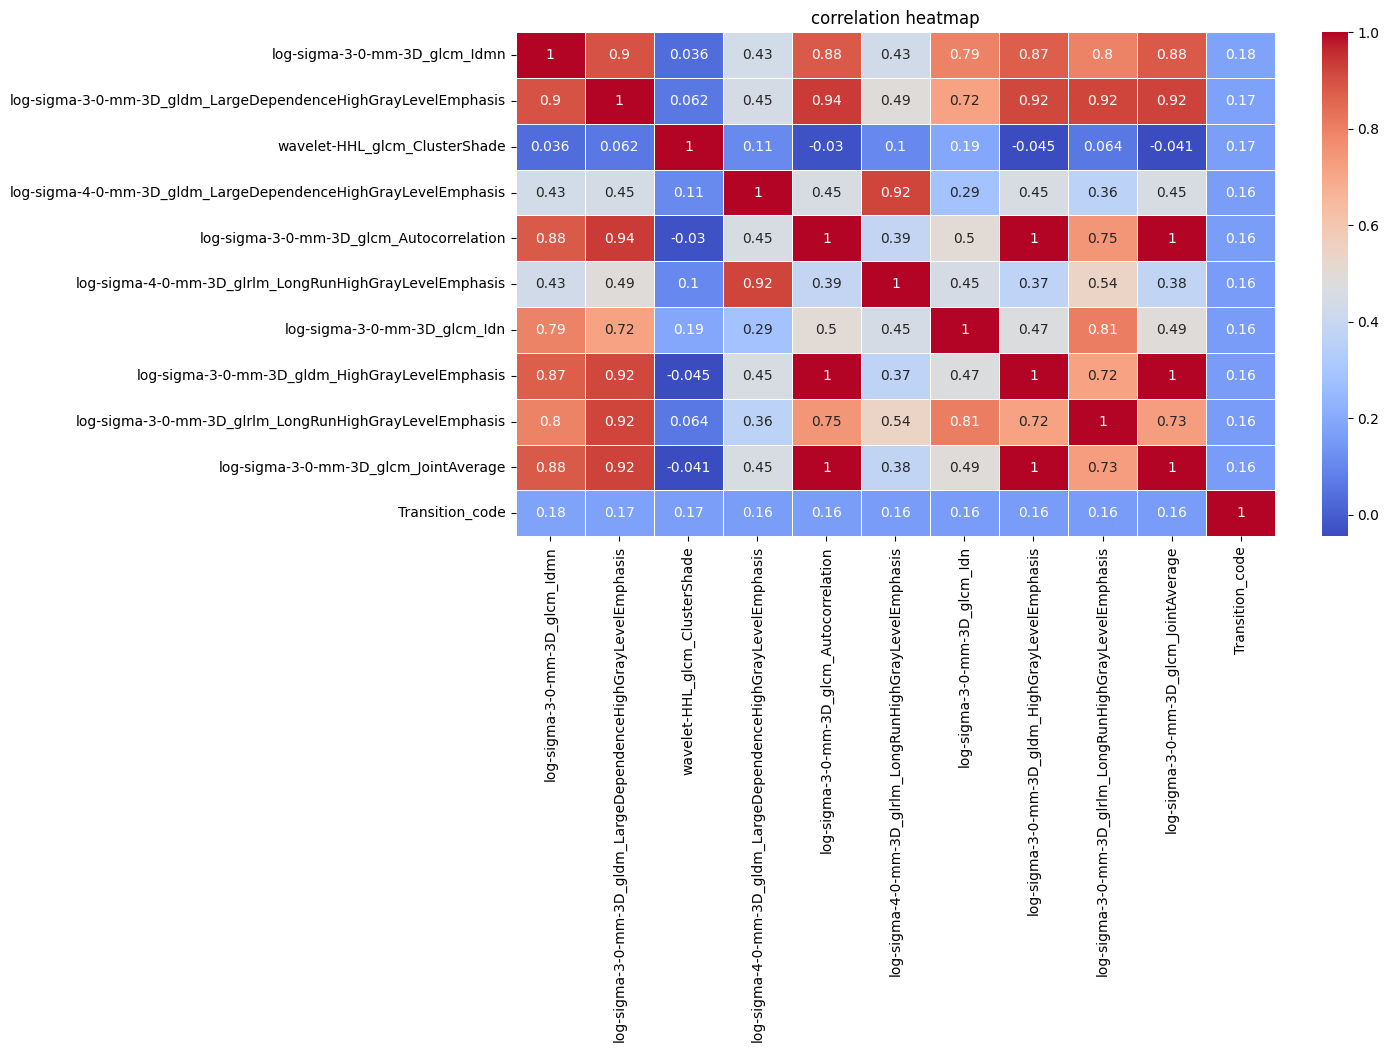

In [33]:
top_features = correlation_matrix.sort_values(ascending=False).head(10).index.tolist()
top_features.append("Transition_code")  
top_features = pd.Index(top_features)  

show_heatmap(train_df[top_features])

## Very Low Correlations
Estas colunas têm um valor de correlação com o target tão baixo que podem ser praticamente dispensadas

In [80]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

KeyError: 'diagnostics_Versions_PyRadiomics'

In [66]:
null_corr_columns = correlation_matrix[(correlation_matrix.abs() < 0.005)].index.tolist()

# Data Preprocessing

## Drop Unnecessary Columns

In [81]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

## Drop Low Corr Columns

In [67]:
train_df = train_df.drop(columns=null_corr_columns,axis=1,errors="ignore")

## Non Numerical Columns Processing

In [89]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

KeyError: 'diagnostics_Mask-original_BoundingBox'

In [87]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

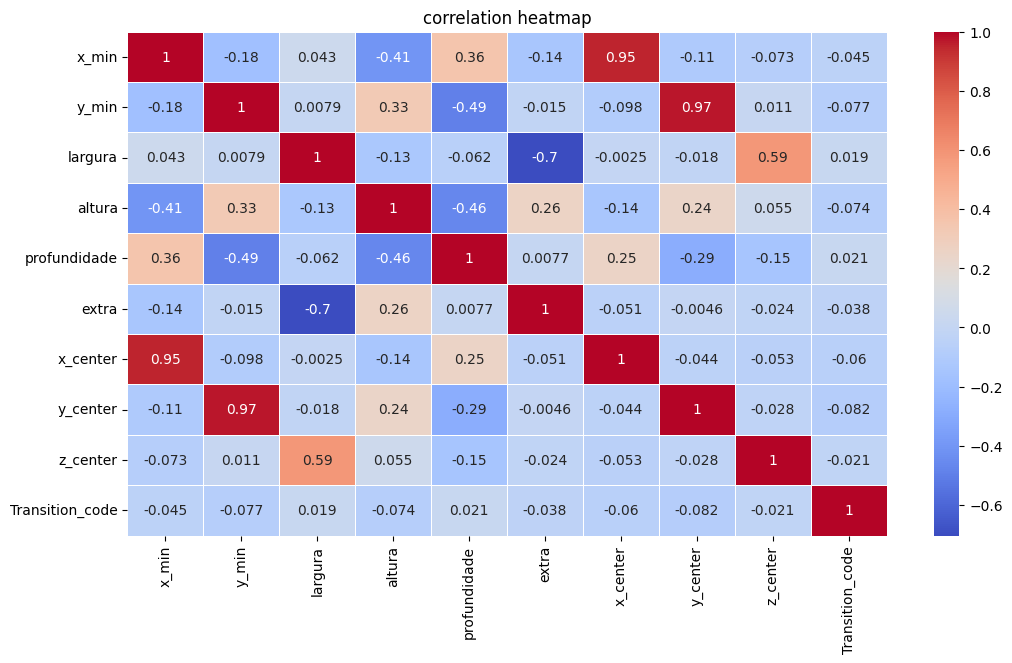

In [90]:
new_numeric_columns = ['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra','x_center', 'y_center', 'z_center',"Transition_code"]
show_heatmap(train_df[new_numeric_columns])

# Testing Phase

In [16]:
new_control_df = control_df.select_dtypes(include="number")
x = new_control_df.drop(columns=["Transition_code"],axis=1)
y = new_control_df["Transition_code"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=101)

lr_model = LogisticRegression(random_state=2001, solver="newton-cg",max_iter=4000)
lr_model.fit(x_train,y_train)
preds = lr_model.predict(x_test)
print(f"Liblinear:\n{classification_report(y_test,preds)}")

Liblinear:
              precision    recall  f1-score   support

           0       0.31      0.69      0.42        16
           1       0.42      0.37      0.39        30
           2       0.00      0.00      0.00         0
           3       0.38      0.29      0.32        21
           4       0.55      0.24      0.33        25

    accuracy                           0.37        92
   macro avg       0.33      0.32      0.29        92
weighted avg       0.42      0.37      0.37        92



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [20]:
x_test = test_df.select_dtypes(include="number")

new_control_df = control_df.select_dtypes(include="number")
x_control = new_control_df.drop(columns=["Transition_code"],axis=1)
y_control = new_control_df["Transition_code"]

new_train_df = train_df.select_dtypes(include="number")
x_train = new_control_df.drop(columns=["Transition_code"],axis=1)
y_train = new_control_df["Transition_code"]

In [23]:
lr_model_newton = LogisticRegression(random_state=2001, solver="newton-cg",max_iter=10000)
lr_model_newton.fit(x_train,y_train)
preds_newton = lr_model_newton.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/optimize.py:318: ConvergenceWarning: newton-cg failed to converge at loss = 0.4834007883603688. Increase the number of iterations.
  warnings.warn(


Predicts newton:
[3 4 3 0 1 3 3 0 4 4 4 4 4 1 3 3 1 0 3 4 4 0 4 1 4 4 3 4 4 0 3 4 4 4 4 4 3
 0 4 4 4 4 0 4 4 0 4 4 4 3 4 4 4 4 0 3 4 4 4 4 1 4 4 4 4 4 4 4 0 0 3 0 4 4
 4 4 4 4 4 4 3 4 1 0 4 4 4 1 0 4 4 0 4 4 4 4 4 4 1 4]


ValueError: Mix of label input types (string and number)

In [27]:
categorical_preds = decode_predicts(le_make_train, preds_newton)

dummy_df["Result"] = categorical_preds

dummy_df.to_csv("../Dataset/dummy_submission.csv",index=False)

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


0     MCI-MCI
1     MCI-MCI
2     MCI-MCI
3     MCI-MCI
4       CN-CN
       ...   
95    MCI-MCI
96      AD-AD
97      CN-CN
98      CN-CN
99      AD-AD
Length: 100, dtype: object
Coluna 'Result' atualizada com sucesso!


C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, m